In [2]:
# Import libraries 
import os 
import numpy as np 
import pandas as pd 
import re 
import matplotlib.pyplot as plt 
import cv2
import tensorflow as tf

In [51]:
# Defining data form of set
data_train = {'img' : [],'mask' : []}
data_test = {'img' : [],'mask' : []}

# Data loader function
def LoadData( data_set = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath) # Get image names
    maskNames = [] # Get mask names   
    for i in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', i)) # L: lablel
    # Get address 
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    # Divide data
    for i in range (len(imgNames)):
        # Read data
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        # Resize the image as 512x512
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        # Divide data
        data_set['img'].append(img)
        data_set['mask'].append(mask)
        
    return data_set

In [57]:
data_train = LoadData( data_train, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels', shape = 256)

In [52]:
data_test  = LoadData( data_test, imgPath = '/kaggle/input/camvid/CamVid/test', maskPath = '/kaggle/input/camvid/CamVid/test_labels', shape = 256)

In [6]:
# Display function: include 2 subplots: image and mask
def DisplayData(data_set = None,index=1):
    plt.subplot(1,2,1)
    plt.imshow(data_set['img'][index])
    plt.title("Image")
    plt.subplot(1,2,2)
    plt.imshow(data_set['mask'][index])
    plt.title("Mask")
    plt.show()

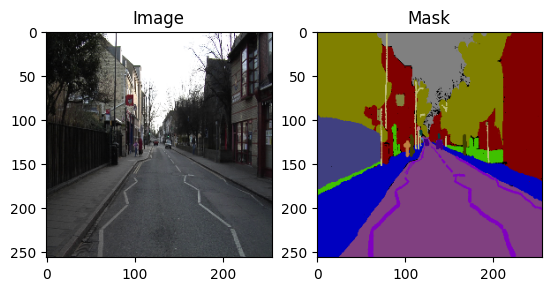

In [61]:
DisplayData(data_train,3)

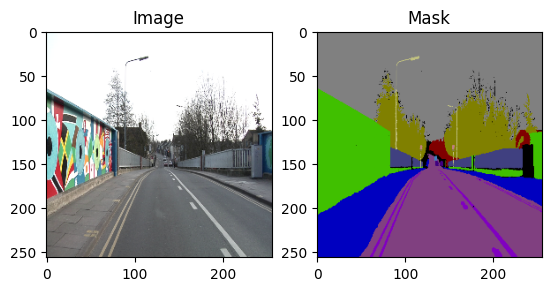

In [59]:
DisplayData(data_test,2)

In [66]:
# Convert data set to array
data_train_img = np.array(data_train['img'])
data_train_mask = np.array(data_train['mask'])

data_test_img = np.array(data_test['img'])
data_test_mask = np.array(data_test['mask'])

data_train = {'img': data_train_img ,'mask' : data_train_mask}
data_test = {'img': data_test_img ,'mask' : data_test_mask}

In [37]:
# Double Convolution 
def DoubleConv(input_tensor, nb_filters, ker_size = 3):
    # 1st Convolution 
    conv = tf.keras.layers.Conv2D(filters=nb_filters, kernel_size = (ker_size,ker_size), kernel_initializer = 'he_normal', padding = 'same') (input_tensor)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation('relu')(conv)
    
    # 2nd Conv
    conv = tf.keras.layers.Conv2D(filters=nb_filters, kernel_size = (ker_size,ker_size), kernel_initializer = 'he_normal', padding = 'same') (conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation('relu')(conv)
    
    return conv

# U-net: there are 2 paths: encoder and decoder ( or contracting path and expansive path)
def UNET (input_image,nb_filters=16,drop_out=0.1):
    # Encoder path (or contracting path)
    '''The contracting path follows the typical architecture of a convolutional network. 
    It consists of the repeated application of two 3x3 convolutions, each followed by a ReLU 
    and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling 
    step we double the number of feature channels.'''
    
    conv1 = DoubleConv(input_image,nb_filters,ker_size=3)
    max_pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)
    max_pool1 = tf.keras.layers.Dropout(drop_out)(max_pool1)
    
    conv2 = DoubleConv(max_pool1,nb_filters*2,ker_size=3)
    max_pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)
    max_pool2 = tf.keras.layers.Dropout(drop_out)(max_pool2)
    
    conv3 = DoubleConv(max_pool2,nb_filters*4,ker_size=3)
    max_pool3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)
    max_pool3 = tf.keras.layers.Dropout(drop_out)(max_pool3)
    
    conv4 = DoubleConv(max_pool3,nb_filters*8,ker_size=3)
    max_pool4 = tf.keras.layers.MaxPooling2D((2,2))(conv4)
    max_pool4 = tf.keras.layers.Dropout(drop_out)(max_pool4)
    
    conv5 = DoubleConv(max_pool4,nb_filters*16,ker_size = 3)
    
    # Decoder path (or expansive path)
    '''. Every step in the expansive path consists of an upsampling of the feature map followed
    by a 2x2 convolution that halves the number of feature channels, a concatenation 
    with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, 
    each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. 
    At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired 
    number of classes. In total the network has 23 convolutional layers.'''
    
    upConv1 = tf.keras.layers.Conv2DTranspose(nb_filters*8, kernel_size= (3,3),strides= (2,2), padding='same')(conv5)
    upConv1 = tf.keras.layers.concatenate([upConv1,conv4])
    upConv1 = tf.keras.layers.Dropout(drop_out)(upConv1)
    conv6 = DoubleConv(upConv1,nb_filters*8,ker_size=3)
    
    upConv2 = tf.keras.layers.Conv2DTranspose(nb_filters*4, kernel_size= (3,3),strides= (2,2), padding='same')(conv6)
    upConv2 = tf.keras.layers.concatenate([upConv2,conv3])
    upConv2 = tf.keras.layers.Dropout(drop_out)(upConv2)
    conv7 = DoubleConv(upConv2,nb_filters*4,ker_size=3)
    
    upConv3 = tf.keras.layers.Conv2DTranspose(nb_filters*2, kernel_size= (3,3) ,strides= (2,2), padding='same')(conv7)
    upConv3 = tf.keras.layers.concatenate([upConv3,conv2])
    upConv3 = tf.keras.layers.Dropout(drop_out)(upConv3)
    conv8 = DoubleConv(upConv3,nb_filters*2,ker_size=3)
    
    upConv4 = tf.keras.layers.Conv2DTranspose(nb_filters, kernel_size= (3,3),strides= (2,2), padding='same')(conv8)
    upConv4 = tf.keras.layers.concatenate([upConv4,conv1])
    upConv4 = tf.keras.layers.Dropout(drop_out)(upConv4)
    conv9 = DoubleConv(upConv4,nb_filters*1,ker_size=3)
    
    out_put = tf.keras.layers.Conv2D(3,(1,1),activation='sigmoid')(conv9)
    model = tf.keras.Model(inputs = [input_image], outputs =[out_put])
    
    return model

In [10]:
# Initial Model
input_image = tf.keras.layers.Input((256,256,3))
myModel = UNET(input_image,drop_out=0.08)
myModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
# Training Model
trainModel = myModel.fit(data_train['img'], data_train['mask'], epochs = 50, verbose = 1) # About 1 hour for 50 epochs

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 112s 8s/step - accuracy: 0.4425 - loss: 0.7339
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.4918 - loss: 0.6530
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5303 - loss: 0.6248
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 102s 8s/step - accuracy: 0.5639 - loss: 0.6018
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5863 - loss: 0.5873
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 102s 8s/step - accuracy: 0.5829 - loss: 0.5722
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5587 - loss: 0.5663
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5619 - loss: 0.5565
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.5741 - loss: 0.5494
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5576 - loss: 0.5404
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 8s/step - accuracy: 0.5622 - loss: 0.5357
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy:

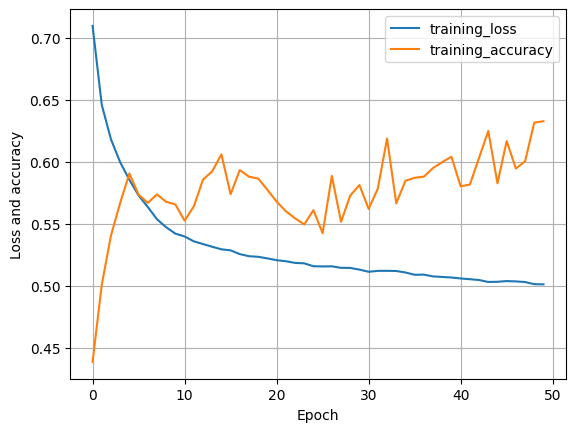

In [16]:
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.plot(trainModel.history['loss'], label = 'training_loss')
plt.plot(trainModel.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [38]:
# Prediction 
def predict (data_test, model, shape = 256):
    ## getting and proccessing test dataset
    image = data_test['img']
    mask = data_test['mask']
    
    predictions = model.predict(image)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, image , mask

# Display predicted results
def show_predictions (image, prediction , mask):
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title('Image')
    
    plt.subplot(1,3,2)
    plt.imshow(prediction)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.title('Actual Mask')

8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


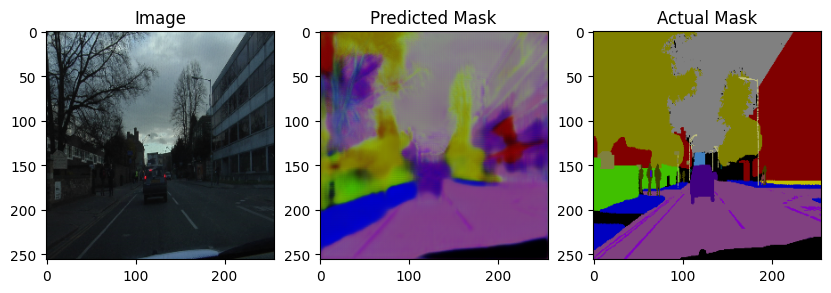

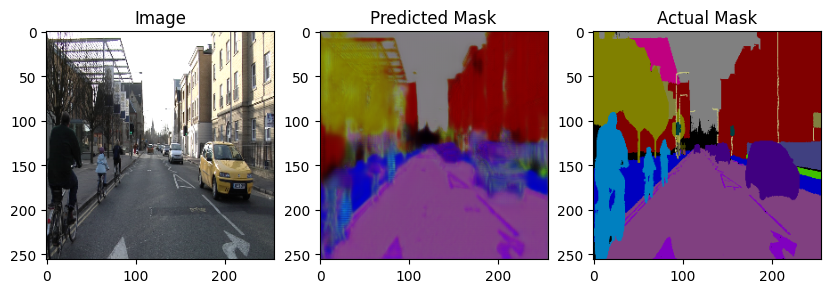

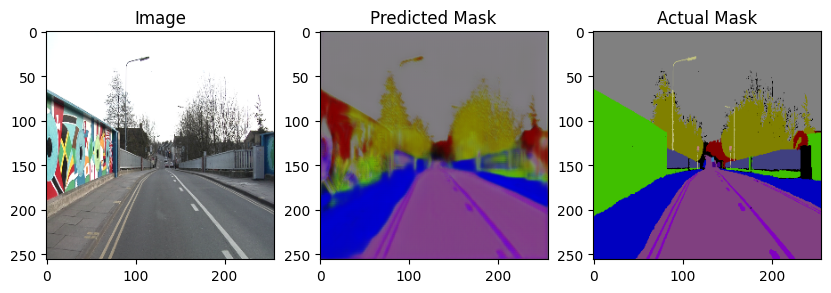

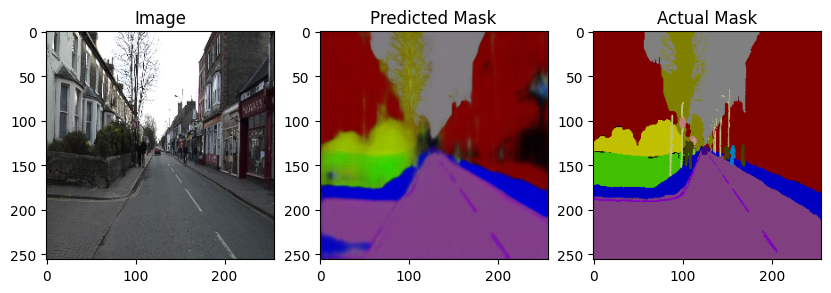

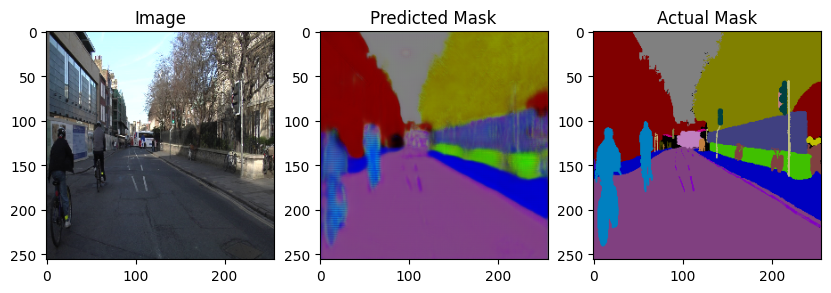

In [55]:
# Get predict results
predictions, image, mask = predict(data_test,myModel)

# Show some examples 
for i in range(5):
    show_predictions(image[i],predictions[i],mask[i])

We can see that this model can predict some objects in the image after 50 epochs of training, but they are still not clear. Therefore, to address this issue, we need to train the model for more epochs, for example, 300 or 500.

In [68]:
# Initial Model
input_image = tf.keras.layers.Input((256,256,3))
myNewModel = UNET(input_image,drop_out=0.08)
myNewModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Training Model
trainNewModel = myNewModel.fit(data_train['img'], data_train['mask'], epochs = 100, verbose = 1) 

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 115s 9s/step - accuracy: 0.4574 - loss: 0.7201
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 104s 9s/step - accuracy: 0.4193 - loss: 0.6497
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.4688 - loss: 0.6249
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.5242 - loss: 0.6091
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.5159 - loss: 0.5974
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.5161 - loss: 0.5854
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.5197 - loss: 0.5760
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 144s 9s/step - accuracy: 0.5219 - loss: 0.5700
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 139s 9s/step - accuracy: 0.5316 - loss: 0.5638
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 104s 9s/step - accuracy: 0.5102 - loss: 0.5625
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.5159 - loss: 0.5564
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step